# 第九章　自然エネルギー利用設備 / Chapter 9 Natural energy utilization equipment

## 第三節　空気集熱式太陽熱利用設備 / Section 3 Air based solar system

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyhees.section2_1_c import get_n_p
from pyhees.section2_1_b import get_f_prim
from pyhees.section3_1 import get_Q, get_A_HCZ_i
from pyhees.section3_2 import calc_r_env, get_Q_dash, get_eta_H, get_eta_C
from pyhees.section4_1 import calc_heating_load, get_alpha_UT_H_MR, get_alpha_UT_H_OR, calc_cooling_load, calc_heating_mode
from pyhees.section7_1 import calc_E_E_W_d_t, calc_E_G_W_d_t, calc_E_K_W_d_t
from pyhees.section3_1_heatingday import get_heating_flag_d


# 試算例

In [2]:
def get_default_air_based_solar_system():
    base = {'region': 6, 'sol_region': 3, 'A_A': 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51,
            "U_A": 0.87, "eta_A_H": 4.3, "eta_A_C": 2.8, 'L_HWH': None,
            "H_MR": {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False},
            "H_OR": {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False}}

    HW = {'hw_type': 'ガス潜熱回収型給湯機', 'e_rtd': 0.836, 'e_dash_rtd': None, 'hybrid_category': None,
          'bath_function': 'ふろ給湯機(追焚あり)', 'has_bath': True, 'pipe_diameter': '上記以外',
          'kitchen_watersaving_A': False, 'kitchen_watersaving_C': False,  'shower_watersaving_A': False,
          'shower_watersaving_B': False, 'washbowl_watersaving_C': False, 'bath_insulation': False}

    SHC = {'type': '空気集熱式', 'P_alpha': 330, 'fan_sso': False, 'fan_type': 'AC', 'hotwater_use': False,
           'pump_sso': False, 'W_tnk_ass': None, 'V_fan_P0': 300, 'A_col': (3, 5), 'P_beta': (30, 50), 'd0': (0.1, 0.2),
           'd1': (2.0, 2.2), 'm_fan_test': (0.0107, 0.014), 'supply_target': '居室', 'r_A_ufvnt_ass': None, 'ufv_insulation': None}

    return base, HW, SHC


In [3]:
def calc_results(base, HW, SHC):

    L_HWH = base['L_HWH']
    region = base['region']
    sol_region = base['sol_region']
    A_A = base['A_A']
    n_p = get_n_p(A_A)

    # 度をラジアンに変換
    if SHC is not None:
        if SHC['type'] == '空気集熱式':
            SHC['P_alpha'] = np.radians(SHC['P_alpha'])

            P_beta_radians = []
            for P_beta_degree in SHC['P_beta']:
                P_beta_radians = P_beta_radians + [np.radians(P_beta_degree)]

            SHC['P_beta'] = tuple(P_beta_radians)

    # 暖房日の取得
    if SHC != None:
        if SHC['type'] == '空気集熱式':
            A_A = base["A_A"]
            A_MR = base["A_MR"]
            A_OR = base["A_OR"]
            A_env = base["A_env"]
            U_A = base["U_A"]
            eta_A_H = base["eta_A_H"]
            eta_A_C = base["eta_A_C"]
            NV_MR = 0
            NV_OR = 0
            r_A_ufvnt = None
            underfloor_insulation = False
            TS = None
            HEX = None

            mode_C = "居室のみを冷房する方式"
            mode_H = '居室のみを暖房する方式でかつ主たる居室とその他の居室ともに温水暖房を設置する場合に該当しない場合'

            H_MR = base["H_MR"]
            H_OR = base["H_OR"]

            # 床面積の合計に対する外皮の部位の面積の合計の比
            r_env = calc_r_env(method='当該住戸の外皮の部位の面積等を用いて外皮性能を評価する方法',
                               A_env=A_env, A_A=A_A)

            # 熱損失係数
            Q_dash = get_Q_dash(U_A, r_env)
            Q = get_Q(Q_dash)

            # 日射取得係数
            mu_H = get_eta_H(eta_A_H, r_env)
            mu_C = get_eta_C(eta_A_C, r_env)

            # 暖房方式及び運転方法の区分
            mode_MR, mode_OR = calc_heating_mode(
                region=region, H_MR=H_MR, H_OR=H_OR)

            # 暖房負荷
            _, L_dash_H_R_d_t_i = \
                calc_heating_load(region, sol_region, A_A, A_MR, A_OR, Q, mu_H, mu_C, NV_MR, NV_OR, TS, r_A_ufvnt, HEX,
                                  underfloor_insulation, mode_H, mode_C, spec_MR=H_MR, spec_OR=H_OR, mode_MR=mode_MR, mode_OR=mode_OR, SHC=SHC)

            heating_flag_d = get_heating_flag_d(L_dash_H_R_d_t_i)
        else:
            heating_flag_d = None
    else:
        heating_flag_d = None

    temp_E = calc_E_E_W_d_t(n_p, L_HWH, heating_flag_d, region, sol_region, HW, SHC)
    temp_G = calc_E_G_W_d_t(n_p, L_HWH, heating_flag_d, A_A, region, sol_region, HW, SHC)
    temp_K = calc_E_K_W_d_t(n_p, L_HWH, heating_flag_d, A_A, region, sol_region, HW, SHC)

    f_prim = get_f_prim()
    Ene_TOTAL = temp_E * f_prim / 1000 + temp_G + temp_K

    print('給湯用一次エネルギー消費量 = {}MJ/年'.format(np.sum(Ene_TOTAL)))

    return {'Ene_TOTAL': Ene_TOTAL}


In [7]:
def get_each_graph(_results):

    results_sum_day = np.sum(_results.reshape(365,24), axis = 1)
    results_mean_hour = np.mean(_results.reshape(365,24), axis = 0)

    fig = plt.figure(figsize = (20,12))
    grh1 = fig.add_subplot(311)
    grh1.set_ylabel('MJ/h')
    grh1.set_xlabel('hour')
    grh1.plot(_results)

    grh_day = fig.add_subplot(312)
    grh_day.set_ylabel('MJ/d')
    grh_day.set_xlabel('day')
    grh_day.plot(results_sum_day)

    grh_hour = fig.add_subplot(313)
    grh_hour.plot(results_mean_hour)
    grh_hour.set_ylabel('MJ/h')
    grh_hour.set_xlabel('hour')

    plt.show()


# 試算例

### 計算条件1

- 初期条件での計算

In [4]:
base, HW, SHC = get_default_air_based_solar_system()

testcase1 = calc_results(base, HW, SHC)['Ene_TOTAL']


C:\Users\Mizutani\Anaconda3\lib\site-packages\pyhees\data\3-1_HukaData_151019_unifyLDK\IH6x_12_05_212_1SS.csv
C:\Users\Mizutani\Anaconda3\lib\site-packages\pyhees\data\3-1_HukaData_151019_unifyLDK\IH6x_12_05_112_1SS.csv
C:\Users\Mizutani\Anaconda3\lib\site-packages\pyhees\data\3-1_HukaData_151019_unifyLDK\IH6x_12_09_212_1SS.csv
C:\Users\Mizutani\Anaconda3\lib\site-packages\pyhees\data\3-1_HukaData_151019_unifyLDK\IH6x_12_09_112_1SS.csv
C:\Users\Mizutani\Anaconda3\lib\site-packages\pyhees\data\3-1_HukaData_151019_unifyLDK\IC6x_12_05_212_1SS.csv
C:\Users\Mizutani\Anaconda3\lib\site-packages\pyhees\data\3-1_HukaData_151019_unifyLDK\IC6x_12_05_112_1SS.csv
C:\Users\Mizutani\Anaconda3\lib\site-packages\pyhees\data\3-1_HukaData_151019_unifyLDK\IC6x_12_09_212_1SS.csv
C:\Users\Mizutani\Anaconda3\lib\site-packages\pyhees\data\3-1_HukaData_151019_unifyLDK\IC6x_12_09_112_1SS.csv
L_ba = 1339.0568333333335
W_k = 35806.0
W_s = 58690.0
W_w = 9454.0
W_b1 = 0.0
W_b2 = 60300.0
W_ba1 = 0.0
W_dash_k = 3580

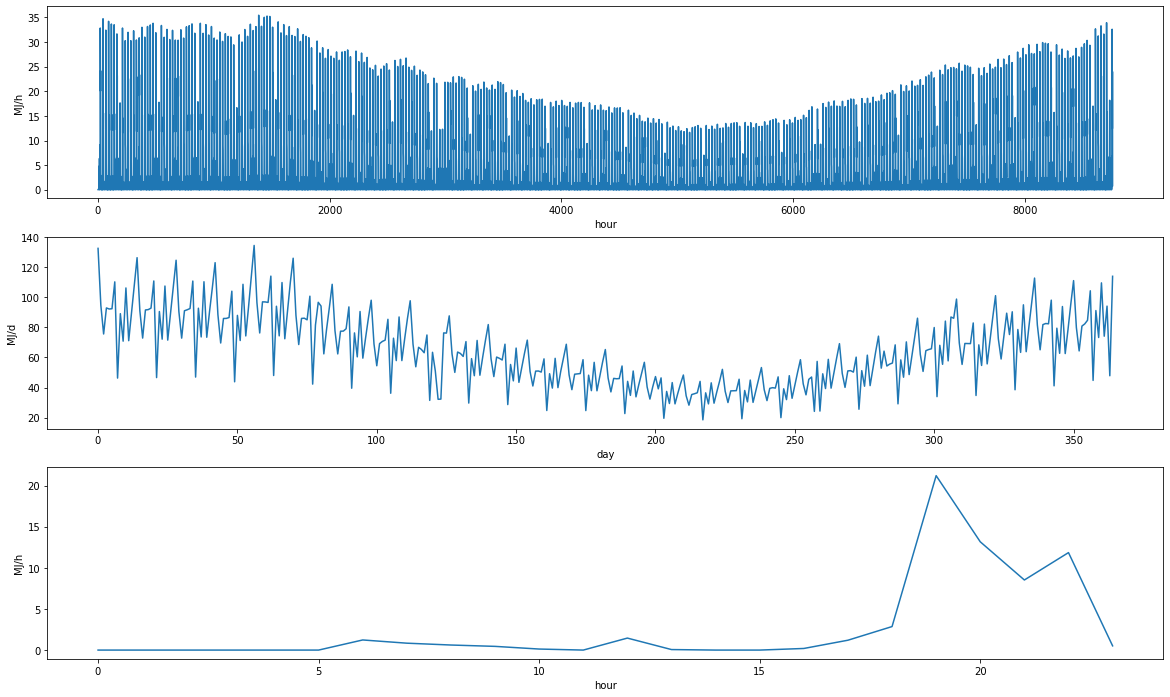

In [8]:
get_each_graph(testcase1)

### 計算条件2

- 給湯利用あり
- タンク容量100L

In [5]:
base, HW, SHC = get_default_air_based_solar_system()

SHC['hotwater_use'] = True
SHC['W_tnk_ass'] = 100


testcase2 = calc_results(base, HW, SHC)['Ene_TOTAL']


L_ba = 1339.0568333333335
W_k = 35806.0
W_s = 58690.0
W_w = 9454.0
W_b1 = 0.0
W_b2 = 60300.0
W_ba1 = 0.0
W_dash_k = 35806.0
W_dash_s = 58690.0
W_dash_w = 9454.0
W_dash_b1 = 0.0
W_dash_b2 = 60300.0
W_dash_ba1 = 0.0
L_dash_k = 3622.896051970286
L_dash_s = 5940.34804910638
L_dash_w = 957.2672611235673
L_dash_b1 = 0.0
L_dash_b2 = 6097.813467345601
L_dash_ba1 = 0.0
L_dash_ba2 = 1673.8210416666666
L_dashdash_k = 3505.3094044807467
L_dashdash_s = 5737.837079239266
L_dashdash_w = 925.566746522401
L_dashdash_b1 = 0.0
L_dashdash_b2 = 5889.381636305503
L_dashdash_ba1 = 0.0
L_dashdash_ba2 = 1673.8210416666666
E_E_hs_aux1 = 37.22433263888889
E_E_hs_aux2 = 6.513888888888888
E_E_hs_aux3 = 13.686551818865741
給湯用一次エネルギー消費量 = 26059.134559302325MJ/年


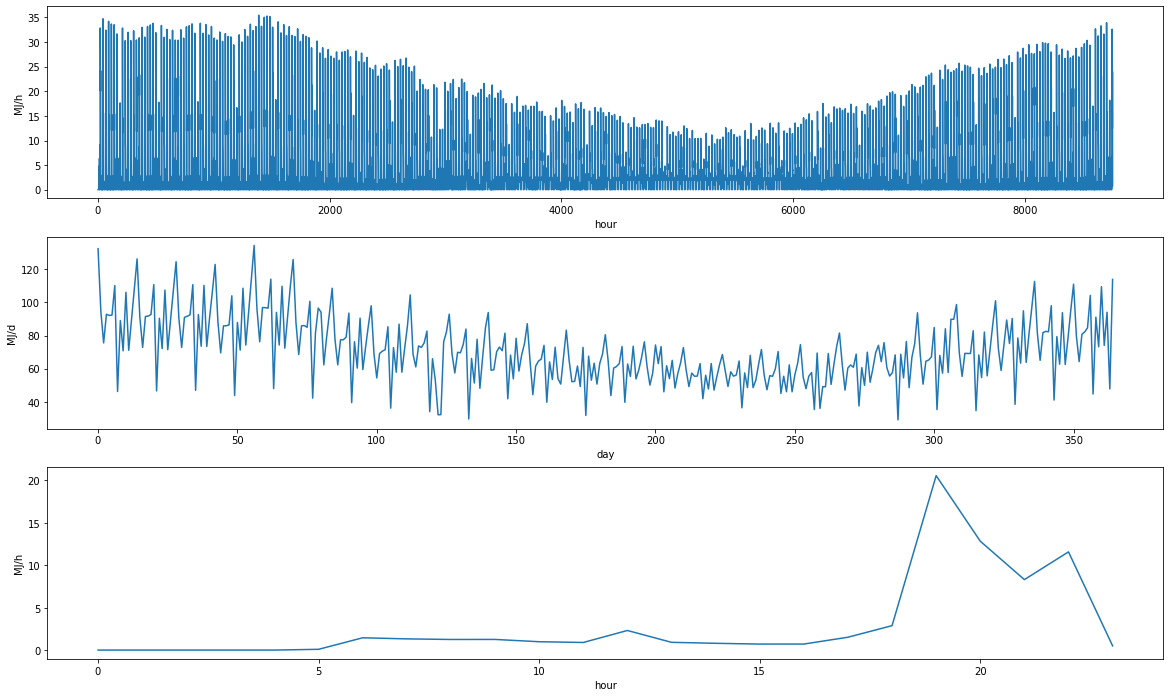

In [9]:
get_each_graph(testcase2)

### 計算条件3

- @@@
- @@@

### 計算条件4

- @@@
- @@@

### 計算条件5

- @@@
- @@@

## 比較